# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
# def separable_conv2d_batchnorm(input_layer, filters, strides=1):
#     output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
#                              padding='same', activation='relu')(input_layer)
    
#     output_layer = keras.layers.Dropout(0.2, noise_shape=None, seed=None)(output_layer)
    
#     output_layer = layers.BatchNormalization()(output_layer) 
    
#     return output_layer

# def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
#     output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
#                       padding='same', activation='relu')(input_layer)
    
#     output_layer = layers.BatchNormalization()(output_layer) 
#     return output_layer

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = keras.layers.Dropout(0.2, noise_shape=None, seed=None)(output_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [4]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, strides):
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
# def decoder_block(small_ip_layer, large_ip_layer, filters):  
#     # TODO Upsample the small input layer using the bilinear_upsample() function.
#     upsampled_layer = bilinear_upsample(small_ip_layer)
    
#     # TODO Concatenate the upsampled and large input layers using layers.concatenate
#     if not large_ip_layer is None:
#         concatenated_layer = layers.concatenate([upsampled_layer, large_ip_layer])
#     else:
#         concatenated_layer = upsampled_layer
    
#     # TODO Add some number of separable convolution layers
#     output_layer_1 = separable_conv2d_batchnorm(concatenated_layer, filters)    
# #     output_layer_2 = separable_conv2d_batchnorm(output_layer_1, filters)    

#     return output_layer_1

In [7]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the small input layer using the bilinear_upsample() function.
    upsample = bilinear_upsample(small_ip_layer)
    
    # Concatenate the upsampled and large input layers using layers.concatenate
    concat_layer = layers.concatenate([upsample, large_ip_layer])

    # Add some number of separable convolution layers
    
    temp_layer = separable_conv2d_batchnorm(concat_layer, filters)
    output_layer = separable_conv2d_batchnorm(temp_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [8]:
# # mine 
# def fcn_model(inputs, num_classes):
       
#     # TODO Add Encoder Blocks. 
#     # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
#     encoder_1 = encoder_block(inputs, 32, 2)
#     encoder_2 = encoder_block(encoder_1, 32, 2)
#     encoder_3 = encoder_block(encoder_2, 32, 2)
#     encoder_4 = encoder_block(encoder_3, 32, 2)

#     # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
#     conv_1x1 = conv2d_batchnorm(encoder_4, 64, kernel_size=1, strides=1)

#     # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
#     decoder_1 = decoder_block(conv_1x1, encoder_3, 32)
#     decoder_2 = decoder_block(decoder_1, encoder_2, 32)
#     decoder_3 = decoder_block(decoder_2, encoder_1, 32)
#     decoder_4 = decoder_block(decoder_3, inputs, 32)
    
#     # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
#     return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_4)
    

In [9]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    layer1 = encoder_block(inputs, 32, 2)
    layer2 = encoder_block(layer1, 64, 2)


    # Add 1x1 Convolution layer using conv2d_batchnorm().
    layer3 = conv2d_batchnorm(layer2, 128, kernel_size=1, strides=1)
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer4 = decoder_block(layer3, layer1, 64)
    layer5 = decoder_block(layer4, inputs, 32)
    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer5)

In [10]:
# old
# def fcn_model(inputs, num_classes):       
#     # TODO Add Encoder Blocks. 
#     # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
#     encoder_1 = encoder_block(inputs, 32, 2)
#     encoder_2 = encoder_block(encoder_1, 48, 2)
#     encoder_3 = encoder_block(encoder_2, 64, 2)
#     encoder_4 = encoder_block(encoder_3, 96, 2)
#     encoder_5 = encoder_block(encoder_4, 128, 2)
# #     encoder_4 = encoder_block(encoder_3, 256, 2)

#     # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
#     conv_1x1 = conv2d_batchnorm(encoder_5, 256, kernel_size=1, strides=1)

#     # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
#     decoder_1 = decoder_block(conv_1x1, encoder_4, 128)
#     decoder_2 = decoder_block(decoder_1, encoder_3, 96)
#     decoder_3 = decoder_block(decoder_2, encoder_2, 64)
#     decoder_4 = decoder_block(decoder_3, encoder_1, 48)
#     decoder_5 = decoder_block(decoder_4, inputs, 32)
# #     decoder_4 = decoder_block(decoder_3, inputs, 32)
    
#     # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
#     return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_5)
    

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [12]:
# learning_rate = 0
# batch_size = 0
# num_epochs = 0
# steps_per_epoch = 200
# validation_steps = 50
# workers = 2

#version 0
# learning_rate = 0.01
# batch_size = 100
# num_epochs = 10
# steps_per_epoch = 200
# validation_steps = 50
# workers = 2

# learning_rate = 0.001
# batch_size = 64
# num_epochs = 75
# steps_per_epoch = 65
# validation_steps = 50
# workers = 2


# learning_rate = 0.001
# batch_size = 40
# num_epochs = 50
# steps_per_epoch =200
# validation_steps = 50
# workers = 2


learning_rate = 0.001
batch_size = 64
num_epochs = 50
steps_per_epoch = 65
validation_steps = 50
workers = 120

Epoch 1/50
64/65 [============================>.] - ETA: 1s - loss: 1.0501

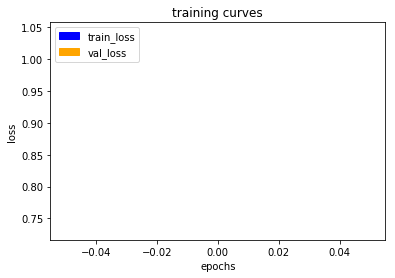

65/65 [==============================] - 152s - loss: 1.0458 - val_loss: 0.7319
Epoch 2/50
64/65 [============================>.] - ETA: 1s - loss: 0.5173

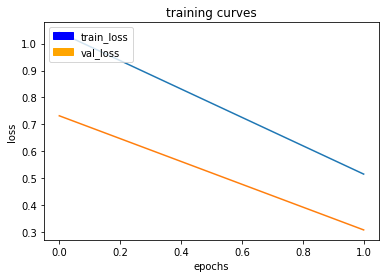

65/65 [==============================] - 144s - loss: 0.5141 - val_loss: 0.3078
Epoch 3/50
64/65 [============================>.] - ETA: 1s - loss: 0.2021

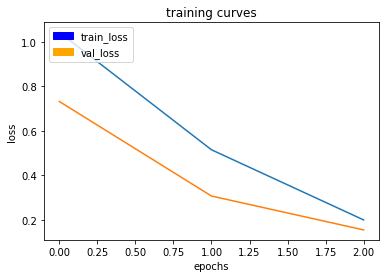

65/65 [==============================] - 122s - loss: 0.2012 - val_loss: 0.1558
Epoch 4/50
64/65 [============================>.] - ETA: 1s - loss: 0.1130

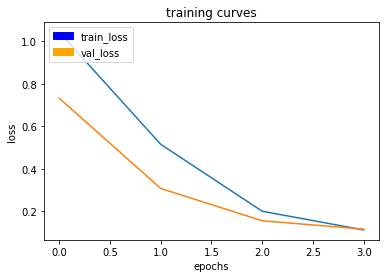

65/65 [==============================] - 143s - loss: 0.1127 - val_loss: 0.1164
Epoch 5/50
64/65 [============================>.] - ETA: 1s - loss: 0.0857

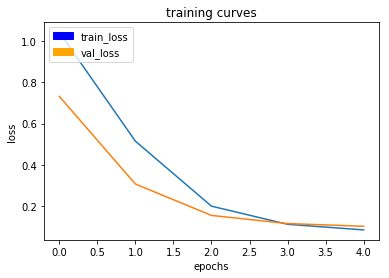

65/65 [==============================] - 123s - loss: 0.0856 - val_loss: 0.1032
Epoch 6/50
64/65 [============================>.] - ETA: 1s - loss: 0.0707

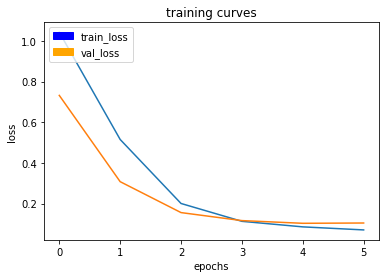

65/65 [==============================] - 144s - loss: 0.0706 - val_loss: 0.1046
Epoch 7/50
64/65 [============================>.] - ETA: 1s - loss: 0.0635

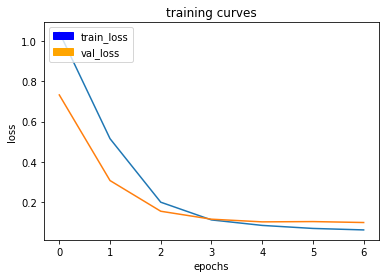

65/65 [==============================] - 122s - loss: 0.0636 - val_loss: 0.1000
Epoch 8/50
64/65 [============================>.] - ETA: 1s - loss: 0.0616

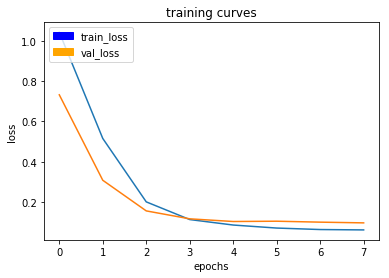

65/65 [==============================] - 143s - loss: 0.0613 - val_loss: 0.0964
Epoch 9/50
64/65 [============================>.] - ETA: 1s - loss: 0.0578

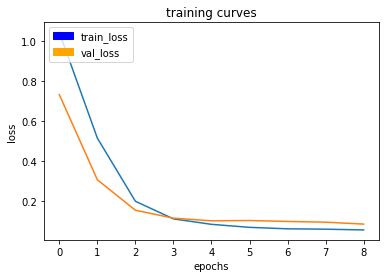

65/65 [==============================] - 122s - loss: 0.0578 - val_loss: 0.0868
Epoch 10/50
64/65 [============================>.] - ETA: 1s - loss: 0.0520

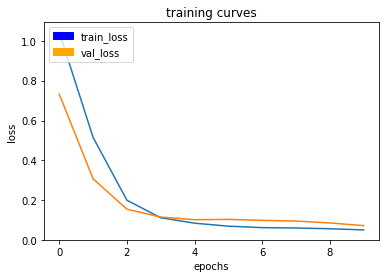

65/65 [==============================] - 142s - loss: 0.0518 - val_loss: 0.0735
Epoch 11/50
64/65 [============================>.] - ETA: 1s - loss: 0.0511

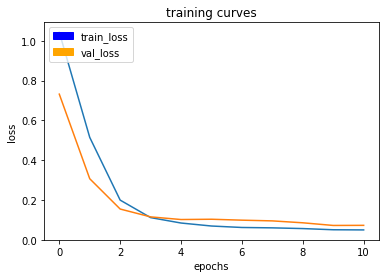

65/65 [==============================] - 123s - loss: 0.0510 - val_loss: 0.0740
Epoch 12/50
64/65 [============================>.] - ETA: 1s - loss: 0.0503

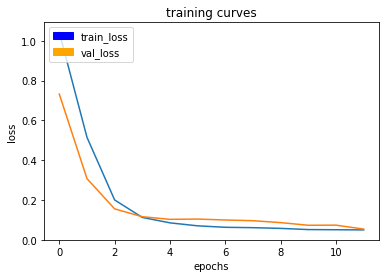

65/65 [==============================] - 142s - loss: 0.0501 - val_loss: 0.0544
Epoch 13/50
64/65 [============================>.] - ETA: 1s - loss: 0.0483

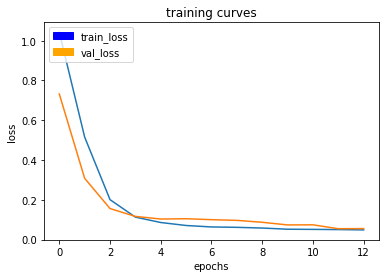

65/65 [==============================] - 123s - loss: 0.0484 - val_loss: 0.0551
Epoch 14/50
64/65 [============================>.] - ETA: 1s - loss: 0.0447

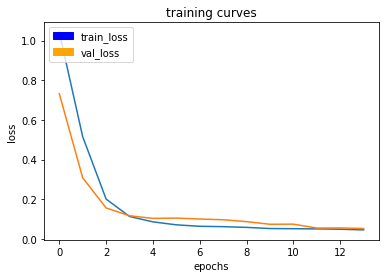

65/65 [==============================] - 142s - loss: 0.0452 - val_loss: 0.0522
Epoch 15/50
64/65 [============================>.] - ETA: 1s - loss: 0.0471

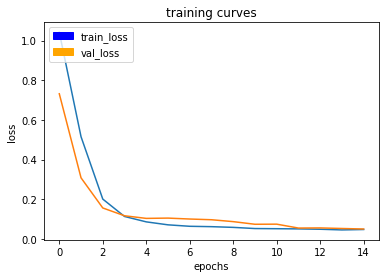

65/65 [==============================] - 123s - loss: 0.0471 - val_loss: 0.0496
Epoch 16/50
64/65 [============================>.] - ETA: 1s - loss: 0.0433

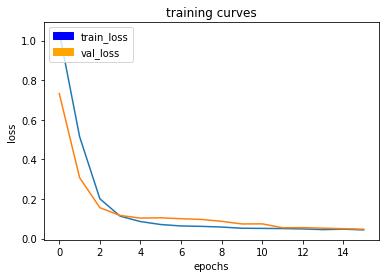

65/65 [==============================] - 143s - loss: 0.0435 - val_loss: 0.0470
Epoch 17/50
64/65 [============================>.] - ETA: 1s - loss: 0.0438

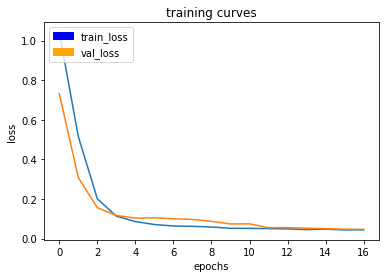

65/65 [==============================] - 123s - loss: 0.0436 - val_loss: 0.0466
Epoch 18/50
64/65 [============================>.] - ETA: 1s - loss: 0.0414

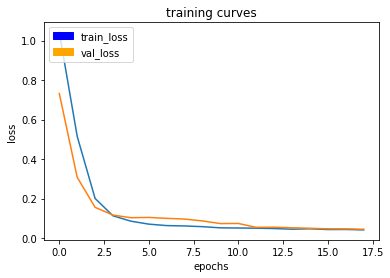

65/65 [==============================] - 142s - loss: 0.0414 - val_loss: 0.0450
Epoch 19/50
64/65 [============================>.] - ETA: 1s - loss: 0.0404

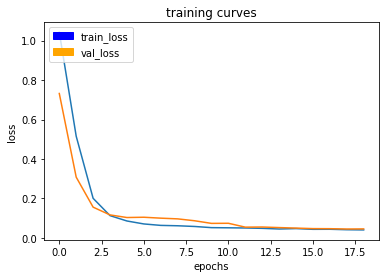

65/65 [==============================] - 124s - loss: 0.0404 - val_loss: 0.0455
Epoch 20/50
64/65 [============================>.] - ETA: 1s - loss: 0.0401

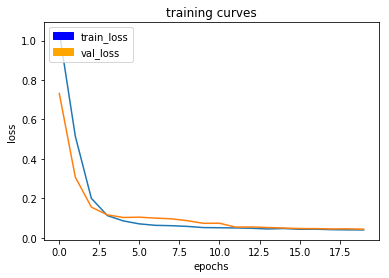

65/65 [==============================] - 143s - loss: 0.0400 - val_loss: 0.0436
Epoch 21/50
64/65 [============================>.] - ETA: 1s - loss: 0.0383

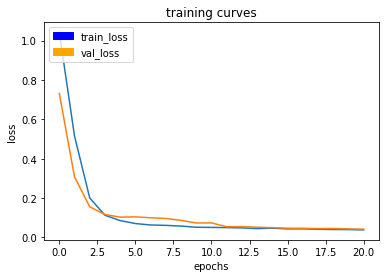

65/65 [==============================] - 121s - loss: 0.0382 - val_loss: 0.0422
Epoch 22/50
64/65 [============================>.] - ETA: 1s - loss: 0.0393

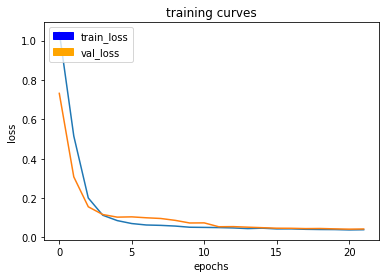

65/65 [==============================] - 145s - loss: 0.0393 - val_loss: 0.0431
Epoch 23/50
64/65 [============================>.] - ETA: 1s - loss: 0.0376

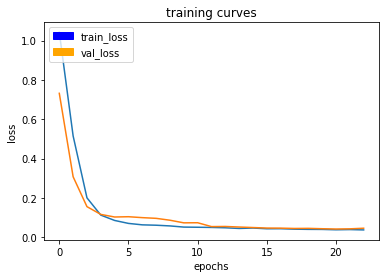

65/65 [==============================] - 122s - loss: 0.0375 - val_loss: 0.0461
Epoch 24/50
64/65 [============================>.] - ETA: 1s - loss: 0.0395

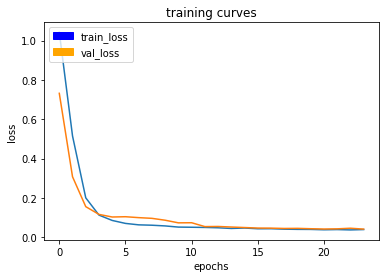

65/65 [==============================] - 144s - loss: 0.0393 - val_loss: 0.0416
Epoch 25/50
64/65 [============================>.] - ETA: 1s - loss: 0.0384

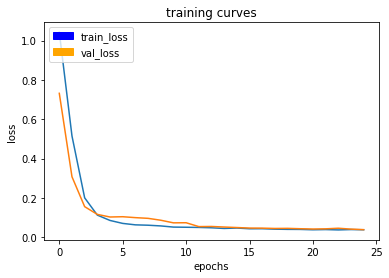

65/65 [==============================] - 123s - loss: 0.0383 - val_loss: 0.0389
Epoch 26/50
64/65 [============================>.] - ETA: 1s - loss: 0.0349

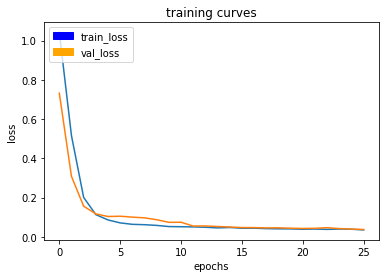

65/65 [==============================] - 143s - loss: 0.0348 - val_loss: 0.0370
Epoch 27/50
64/65 [============================>.] - ETA: 1s - loss: 0.0358

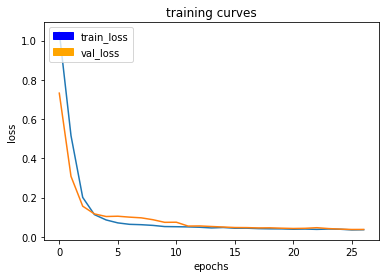

65/65 [==============================] - 122s - loss: 0.0357 - val_loss: 0.0372
Epoch 28/50
64/65 [============================>.] - ETA: 1s - loss: 0.0355

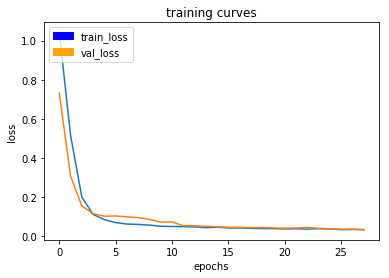

65/65 [==============================] - 143s - loss: 0.0354 - val_loss: 0.0334
Epoch 29/50
64/65 [============================>.] - ETA: 1s - loss: 0.0341

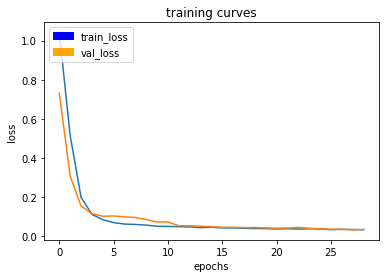

65/65 [==============================] - 123s - loss: 0.0343 - val_loss: 0.0358
Epoch 30/50
64/65 [============================>.] - ETA: 1s - loss: 0.0347

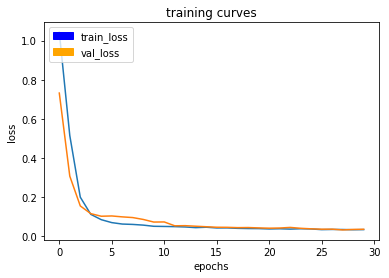

65/65 [==============================] - 143s - loss: 0.0352 - val_loss: 0.0367
Epoch 31/50
64/65 [============================>.] - ETA: 1s - loss: 0.0353

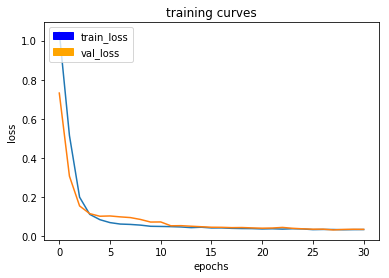

65/65 [==============================] - 123s - loss: 0.0353 - val_loss: 0.0362
Epoch 32/50
64/65 [============================>.] - ETA: 1s - loss: 0.0330

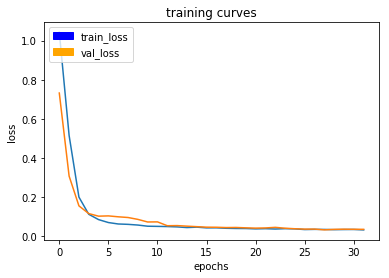

65/65 [==============================] - 144s - loss: 0.0330 - val_loss: 0.0360
Epoch 33/50
64/65 [============================>.] - ETA: 1s - loss: 0.0326

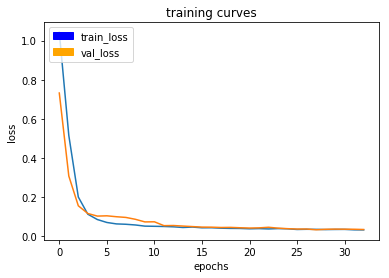

65/65 [==============================] - 123s - loss: 0.0325 - val_loss: 0.0347
Epoch 34/50
64/65 [============================>.] - ETA: 1s - loss: 0.0342

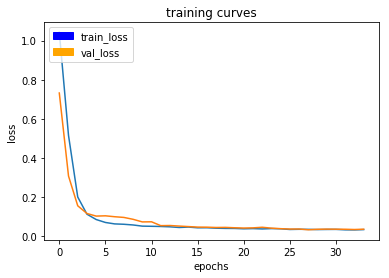

65/65 [==============================] - 144s - loss: 0.0342 - val_loss: 0.0363
Epoch 35/50
64/65 [============================>.] - ETA: 1s - loss: 0.0328

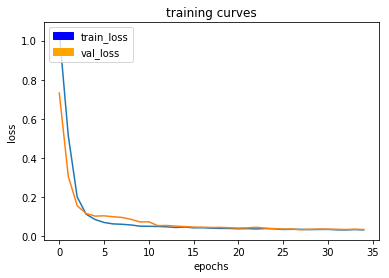

65/65 [==============================] - 122s - loss: 0.0330 - val_loss: 0.0344
Epoch 36/50
64/65 [============================>.] - ETA: 1s - loss: 0.0323

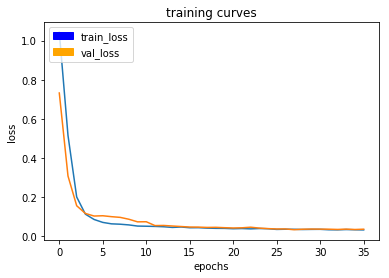

65/65 [==============================] - 143s - loss: 0.0322 - val_loss: 0.0359
Epoch 37/50
64/65 [============================>.] - ETA: 1s - loss: 0.0320

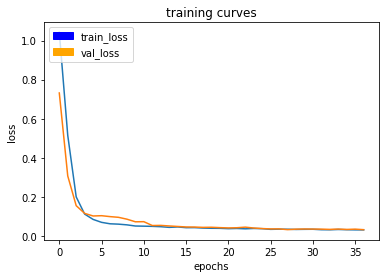

65/65 [==============================] - 121s - loss: 0.0319 - val_loss: 0.0332
Epoch 38/50
64/65 [============================>.] - ETA: 1s - loss: 0.0317

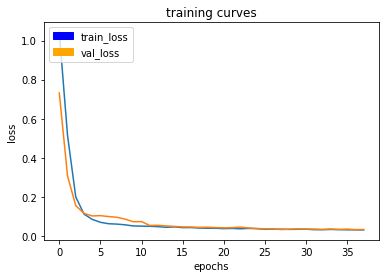

65/65 [==============================] - 143s - loss: 0.0317 - val_loss: 0.0338
Epoch 39/50
64/65 [============================>.] - ETA: 1s - loss: 0.0323

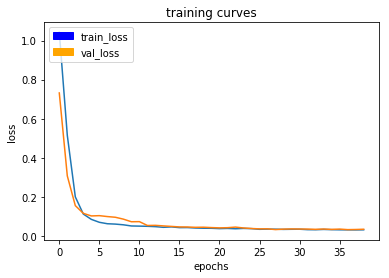

65/65 [==============================] - 122s - loss: 0.0322 - val_loss: 0.0352
Epoch 40/50
64/65 [============================>.] - ETA: 1s - loss: 0.0312

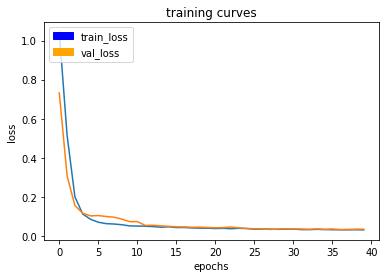

65/65 [==============================] - 145s - loss: 0.0313 - val_loss: 0.0350
Epoch 41/50
64/65 [============================>.] - ETA: 1s - loss: 0.0314

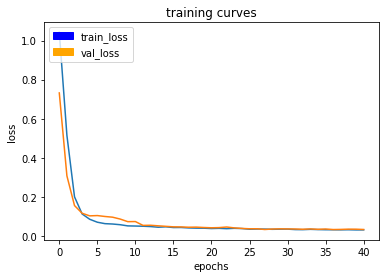

65/65 [==============================] - 123s - loss: 0.0313 - val_loss: 0.0334
Epoch 42/50
64/65 [============================>.] - ETA: 1s - loss: 0.0310

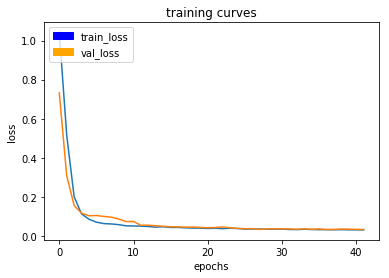

65/65 [==============================] - 143s - loss: 0.0309 - val_loss: 0.0333
Epoch 43/50
64/65 [============================>.] - ETA: 1s - loss: 0.0313

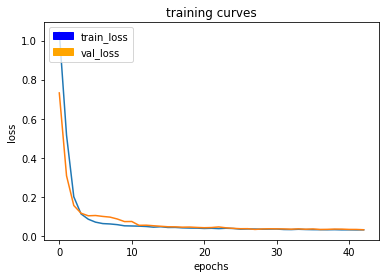

65/65 [==============================] - 123s - loss: 0.0312 - val_loss: 0.0318
Epoch 44/50
64/65 [============================>.] - ETA: 1s - loss: 0.0306

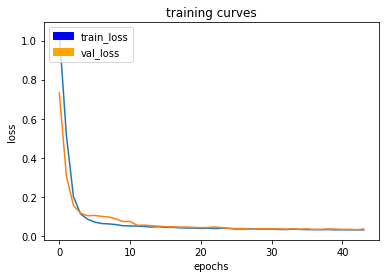

65/65 [==============================] - 143s - loss: 0.0306 - val_loss: 0.0350
Epoch 45/50
64/65 [============================>.] - ETA: 1s - loss: 0.0318

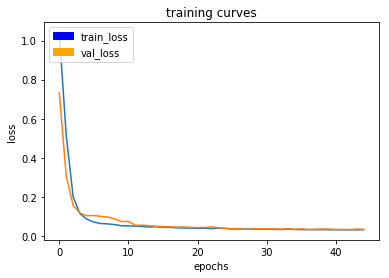

65/65 [==============================] - 123s - loss: 0.0317 - val_loss: 0.0335
Epoch 46/50
64/65 [============================>.] - ETA: 1s - loss: 0.0291

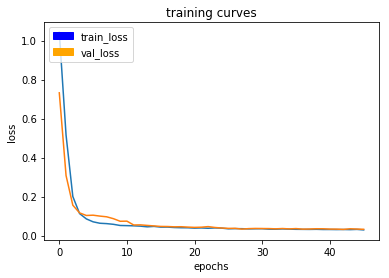

65/65 [==============================] - 144s - loss: 0.0292 - val_loss: 0.0324
Epoch 47/50
64/65 [============================>.] - ETA: 1s - loss: 0.0282

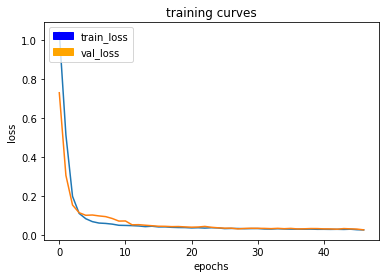

65/65 [==============================] - 123s - loss: 0.0281 - val_loss: 0.0285
Epoch 48/50
64/65 [============================>.] - ETA: 1s - loss: 0.0321

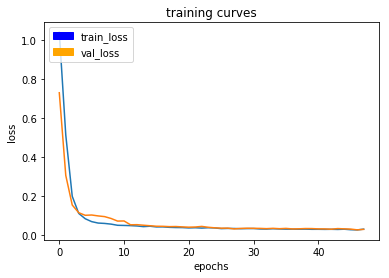

65/65 [==============================] - 143s - loss: 0.0320 - val_loss: 0.0310
Epoch 49/50
64/65 [============================>.] - ETA: 1s - loss: 0.0303

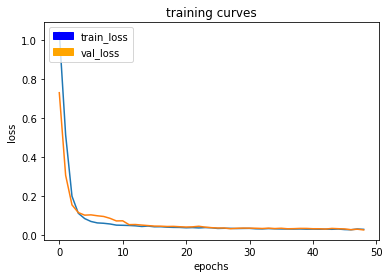

65/65 [==============================] - 123s - loss: 0.0303 - val_loss: 0.0273
Epoch 50/50
64/65 [============================>.] - ETA: 1s - loss: 0.0295

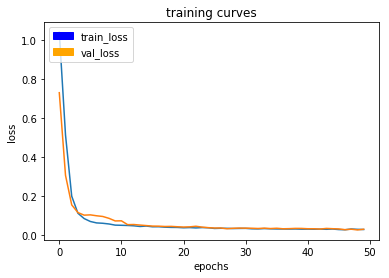

65/65 [==============================] - 143s - loss: 0.0294 - val_loss: 0.0308


In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

from workspace_utils import active_session
# Keeping Your Session Active
with active_session():
    # Define the Keras model and compile it for training
    model = models.Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

    # Data iterators for loading the training and validation data
    train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                   data_folder=os.path.join('..', 'data', 'train'),
                                                   image_shape=image_shape,
                                                   shift_aug=True)

    val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                                 data_folder=os.path.join('..', 'data', 'validation'),
                                                 image_shape=image_shape)

    logger_cb = plotting_tools.LoggerPlotter()
    callbacks = [logger_cb]

    model.fit_generator(train_iter,
                        steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                        epochs = num_epochs, # the number of epochs to train for,
                        validation_data = val_iter, # validation iterator
                        validation_steps = validation_steps, # the number of batches to validate on
                        callbacks=callbacks,
                        workers = workers)

In [14]:
# Save your trained model weights
weight_file_name = 'model_weights_v40'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [15]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights_v40'
restored_model = model_tools.load_network(weight_file_name)
model = restored_model

# from keras.utils import plot_model
# plot_model(model, to_file='/home/workspace/RoboND-DeepLearning-Project/model.png')



The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [16]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

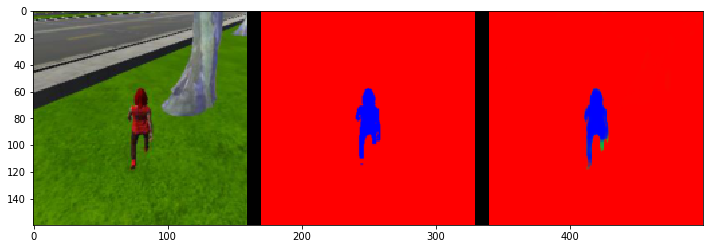

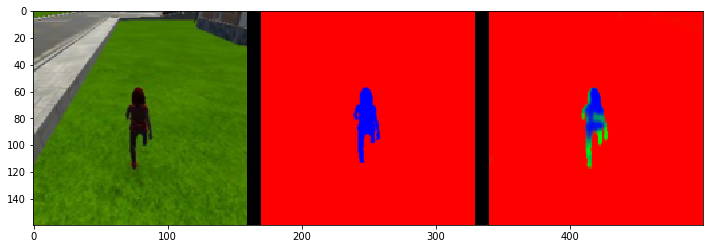

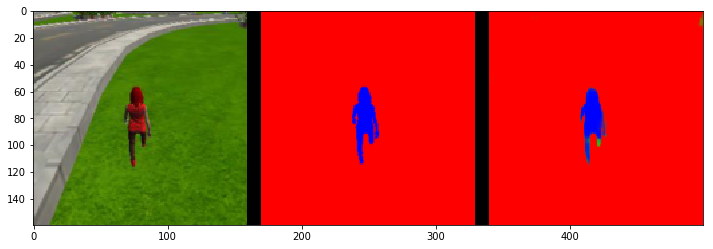

In [17]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

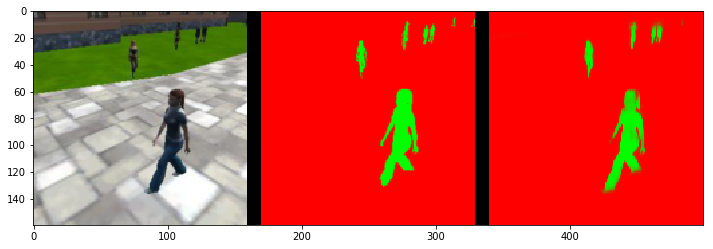

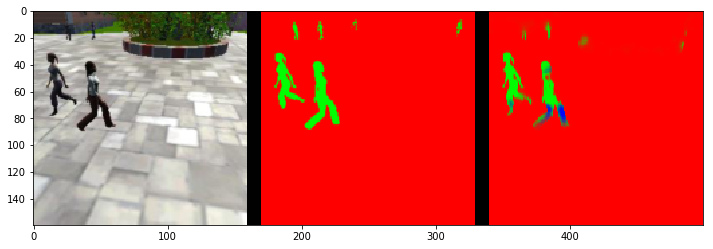

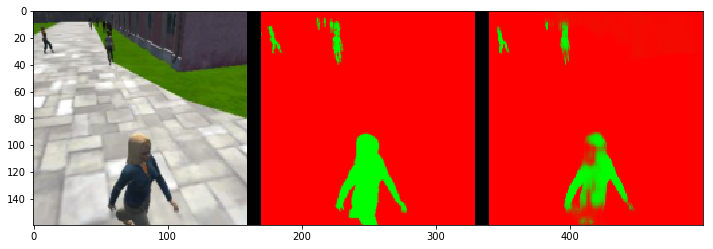

In [18]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

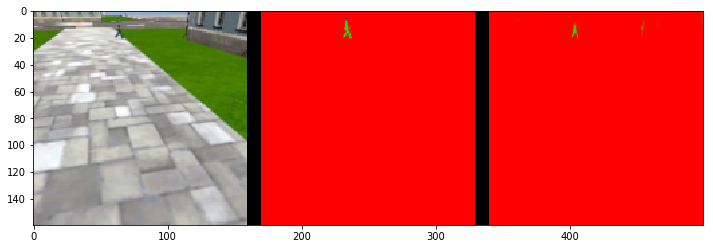

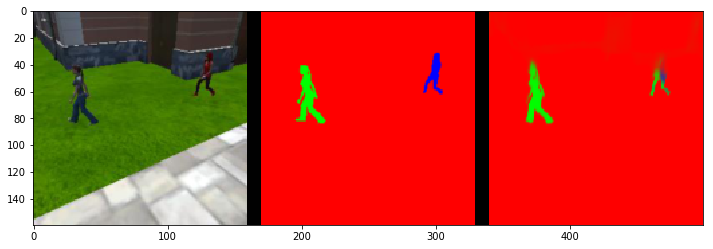

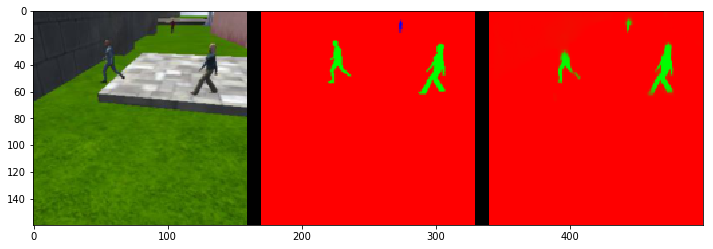

In [19]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [20]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9944709956546594
average intersection over union for other people is 0.273830730809987
average intersection over union for the hero is 0.8390073561429928
number true positives: 539, number false positives: 0, number false negatives: 0


In [21]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9800293957731054
average intersection over union for other people is 0.5901583052425177
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 46, number false negatives: 0


In [22]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9954723433915356
average intersection over union for other people is 0.3745856096700545
average intersection over union for the hero is 0.14199403917973946
number true positives: 107, number false positives: 1, number false negatives: 194


In [23]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7282976324689966


In [24]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.490500697661


In [25]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.357230496831


  # Version 0
0.325761

32>64>128
learning_rate = 0.01
batch_size = 100
num_epochs = 10
steps_per_epoch = 200
validation_steps = 50
workers = 2

# Version 1
0.372833

32>64>128
learning_rate = 0.001
batch_size = 64
num_epochs = 50
steps_per_epoch = 65
validation_steps = 50
workers = 120


# Version 2
0.327704

64>128
learning_rate = 0.001
batch_size = 64
num_epochs = 50
steps_per_epoch = 65
validation_steps = 50
workers = 120


# Version 3
0.3523

32>64>128>256
learning_rate = 0.001
batch_size = 64
num_epochs = 50
steps_per_epoch = 65
validation_steps = 50
workers = 120\


# Version 4
0.381812034026

32>64>128
learning_rate = 0.001
batch_size = 64
num_epochs = 50
steps_per_epoch = 65
validation_steps = 50
workers = 2

# Version 5

0.182040551041

32>64>128
learning_rate = 0.0001
batch_size = 64
num_epochs = 15
steps_per_epoch = 65
validation_steps = 50
workers = 2


# Version 6
0.292970013705

32>64>128
learning_rate = 0.0001
batch_size = 64
num_epochs = 50
steps_per_epoch = 65
validation_steps = 50
workers = 2


# Version 7

0.314219652304

32>64>128
learning_rate = 0.001
batch_size = 64
num_epochs = 15
steps_per_epoch = 65
validation_steps = 50
workers = 2
2 layers in decode


# Version 8

0.31011124538

32>64>128
learning_rate = 0.001
batch_size = 64
num_epochs = 15
steps_per_epoch = 65
validation_steps = 50
workers = 2

num_epochs = 30
0.3484753506

num_epochs = 75
0.371339311164


# Version 9
0.320662658719

32>48>64>96>128

learning_rate = 0.001
batch_size = 64
num_epochs = 75
steps_per_epoch = 65
validation_steps = 50
workers = 2

# Version 10

0.379423992255

32>64>128

learning_rate = 0.003
batch_size = 40
num_epochs = 50
steps_per_epoch =400
validation_steps = 50
workers = 8


# Version 11 

0.361159504814

32>32>32

learning_rate = 0.003
batch_size = 40
num_epochs = 25
steps_per_epoch =400
validation_steps = 50
workers = 8


# Version 12 

0.38079040756

32>32>32

learning_rate = 0.001
batch_size = 40
num_epochs = 40
steps_per_epoch =400
validation_steps = 50
workers = 8


# Version 13

0.417410466065

32>32>32>32

learning_rate = 0.001
batch_size = 40
num_epochs = 60
steps_per_epoch =400
validation_steps = 50
workers = 8


# Version 14

0.388324795759

32>32>32>32

learning_rate = 0.0005
batch_size = 40
num_epochs = 60
steps_per_epoch =400
validation_steps = 50
workers = 8



# Version 15

0.366565355974

32>32>32>32>32

learning_rate = 0.001
batch_size = 40
num_epochs = 20
steps_per_epoch =400
validation_steps = 50
workers = 8



# Version 17

0.359422293599

16>16>16>16>16

learning_rate = 0.001
batch_size = 40
num_epochs = 20
steps_per_epoch =400
validation_steps = 50
workers = 8



# Version 18
0.334131085394

16>16>16>16

learning_rate = 0.001
batch_size = 40
num_epochs = 20
steps_per_epoch =400
validation_steps = 50
workers = 8



# Version 19

0.358344808204

16>32>32>64

learning_rate = 0.001
batch_size = 40
num_epochs = 40
steps_per_epoch =400
validation_steps = 50
workers = 8

# Version 20

0.401914136701

19 + dropout (0.2) to encoders


# Version 21

0.364570620874

13 + dropout (0.2) to encoders
num_epochs = 40


# Version 22

0.404508001243

Version 21, another 40 epochs of training


# Version 23

0.344181952421

Version 21, +

learning_rate = 0.0001
batch_size = 40
num_epochs = 60
steps_per_epoch = 400
validation_steps = 50
workers = 8


# Version 24
0.396371039899

Version 21, +

learning_rate = 0.0005
batch_size = 40
num_epochs = 60
steps_per_epoch = 400
validation_steps = 50
workers = 8


# Version 25

0.387

32>32>32>32

learning_rate = 0.001
batch_size = 40
num_epochs = 60
steps_per_epoch =400
validation_steps = 50
workers = 8
no dropout


# Version 26

0.3436

version 13 + num_epochs = 20


# Version 27

0.3751

version 13 + num_epochs = 20 + dropout (0.2)

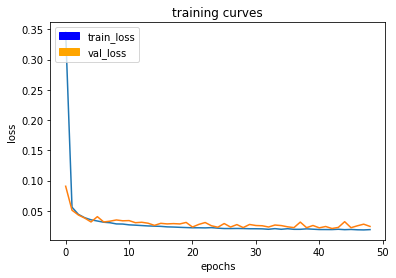


# Version 28

0.3489

version 13 + num_epochs = 20 + dropout (0.2) + no direct connection for first 2 decoders

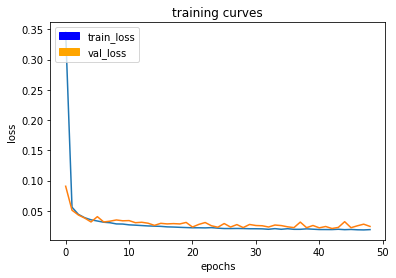


# Version 29

0.382335857696


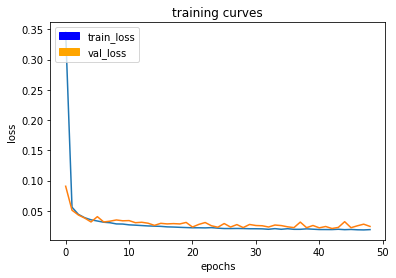

version 13 + num_epochs = 50 + dropout (0.2)


# Version 30

0.371

Another 10 iteration with half step


# Version 31

0.368403766964

version 13 , dropout (0.2)

learning_rate = 0.001
batch_size = 40
num_epochs = 50
steps_per_epoch =200
validation_steps = 50
workers = 2


# Version 32

0.425432710746

ver.31 but move dropout before normalization


# Version 33


16>32>64>128

0.3611

# Version 34

32>32>64>64

0.37


# Version 35

0.36

32>32>32>32 16

Version 32 but instead of using 64 filteer on the 1x1 layer I use 16


# Version v32_new

0.340333811112

32>32>32>32 64



# Version v36

32>32>32>32 64

v32_new but move normalization before dropout


# Version 37

0.352

same as v32_new


# Version 38

0.31

Same as v32_new

learning_rate = 0.001
batch_size = 64
num_epochs = 50
steps_per_epoch = 65
validation_steps = 50
workers = 120


# Version 39 

(saved html)
0.406413669057

64>128, 256


# Version 40 

v39 + dropout, 32>64, 128

0.357
